# Workshop 1. Basic dynamics: deterministic SIR

#### This notebook was developed by Dr Rabia Aziza (rabia.aziza@warwick.ac.uk)

$\\ \ \\ \ \\ $

## 1. Context of the course
### 1.1 Purpose  and scope of the course 
This material has been developed as part of the *GeMVi* project: *NIHR Global Health Research Group on the Application of Genomics and Modelling to the Control of Virus Pathogens* in East Africa and the University of Warwick.

In these workshops you will be introduced to some common techniques used in infectious disease modelling. The topics covered will include the implementation of deterministic and stochastic compartmental models, the use of maximum likelihood estimation to analyse super-spreading behaviour in novel disease outbreaks, modelling of contact patterns, and optimisation techniques for fitting epidemic models to real data.

### 1.2 Authors/Contributors
The contributors are all part of the GeMVi project:
- Prof James Nokes (JNokes@kemri-wellcome.org)
- Prof Matt Keeling (m.j.keeling@warwick.ac.uk)
- Dr Joe Hilton (j.hilton@warwick.ac.uk)
- Dr Rabia Aziza (rabia.aziza@warwick.ac.uk)
- Dr Samuel Brand (s.brand@warwick.ac.uk)
- Dr Andrea Parisi (andrea.parisi@warwick.ac.uk)

### 1.3 Helpful references for the course
- Anderson, R. M., & May, R. M. (1992). Infectious Diseases of Humans: Dynamics and Control.
- Bjørnstad, O. N. (2018). Epidemics, models and data using R. https://doi.org/10.1007/978-3-319-97487-3
- Diekmann, O., & Heesterbeek, J. A. P. (2000). Mathematical epidemiology of infectious diseases: model building, analysis and interpretation. 104: John Wiley and Sons.
- Keeling, Matt J., & Pejman Rohani. Modeling Infectious Diseases in Humans and Animals. Princeton University Press, 2008.
- Vynnycky, Emilia, & White, Richard G. An Introduction to Infectious Disease Modelling

## 2. Background

### 2.1 Mathematical models of infectious diseases

Infectious diseases represent a major cause of illness and mortality in humans and non-human animals. They are caused by pathogens, living entities such as viruses, bacteria, or helminths (worms). Transmission routes include human-to-human contact (including sexual contacts), vector-borne transmission (transmission from human to human via an intermediate species), or zoonotic transmission (direct transmission to humans from an animal reservoir). Sustained human-to-human transmission results in an outbreak of infection, which can have several different outcomes:
- Epidemic infection: a sudden outbreak of infection that acts on a short temporal scale;
- Pandemic: a large-scale outbreak which spreads between continents;
- Endemic infection: an infection that establishes itself over a long time scale in a particular region or population.
Effective modelling of infectious disease dynamics requires us to choose the right tools for pathogen, host population, and type of outbreak we are dealing with. Vector-borne diseases require different models to human-to-human transmissible infections, and the dynamics of endemic infections require different considerations to those of novel infections.

We can divide infectious disease models into two broad classes:
- **Deterministic models** describe the infectious disease dynamics using a set of rate-based equations. These models are accurate in large populations where the population is approximately a continuum.
- **Stochastic models** allow for randomness, and account for the inherently discrete nature of populations of individuals. This makes stochastic models more realistic than deterministic ones, but also more challenging to analyse and implement.

In this notebook we will introduce the basics of deterministic modelling.

### 2.2 Compartmental models 

Compartmental models are the most widely-used class of model in infectious disease dynamics (and are common in many other areas of mathematical biology). Each individual in the population is assigned to a compartment based on some characteristic of interest, with individuals in the same compartment sharing the same status *(W3)*. The infectious disease dynamics are determined by the interactions between people of different compartments. The key to formulating such a model is to choose a set of compartments and transitions which are appropriate to the situation we want to model. In this workshop we will introduce a few commonly used compartmental structures, and focus on what is probably the most commonly used of all: the SIR model.

## 3. SIR without demography
### 3.1 Model formulation
To begin with, let's consider a closed population without demography (births and deaths) or migration. The "no demography" assumption is reasonable when we are considering the dynamics of an outbreak over a short timescale, where the expected number of demographic events is much smaller than the expected number of infectious events.
Our host population is divided into three compartments corresponding to different infectious statuses:
- Susceptible ($S$): naive individuals who have no immunity to infection
- Infectious ($I$): individuals who have been infected and are currently able to transmit this infection to susceptible individuals
- Recovered ($R$): individuals who have undergone a period of infection and are now immune to further infection

There are two ways to transition between compartments: a susceptible individual can become infectious, resulting in an $S\to I$ transition, or an infectious individual can recover, resulting in an $I\to R$ transition.

This system can be represented schematically, as follows:
<img src="img/SIR_NoDemography.png" style="width: 30%;"/>
In this workshop, our focus is on translating schematics like this into systems of differential equations, but we emphasise here that they can also be interpreted as a stochastic process.

To define a set of differential equations, we need to assign rates to our infection and recovery events. Let $S(t)$ be the proportion of the population which is susceptible at time $t$, $I(t)$ be the proportion which is infectious, and $R(t)$ be the proportion which is recovered. To obtain an $S\to I$ transition, we need an infectious individual to make an infectious contact with a susceptible individual. If individuals mix homogeneously, then the rate at which these contacts occur will be directly proportional to the proportional sizes of the susceptible and infectious populations, and so we can express this rate as $\beta SI$. The parameter $\beta$ is a per-capita infectious contact rate, defining the rate at which infectious individuals make social contacts **and** transmit infection along these contacts. To obtain an $R\to I$ transmission, we need an infectious individual to recover because their innate immune response has fought off the infection. If the expected amount of time during which a case is infected is given by $T$, then the population-level rate at which recoveries occur will be $\gamma I$, where $\gamma=T^{-1}$.

<img src="img/SIR_NoDemographyBetaGamma.png" style="width: 40%;"/>

These two rates define our entire system, and we obtain a system of three coupled nonlinear ordinary differential equations:

<center>$\left\{\begin{array}{ll}
          \frac{dS}{dt}= -\beta SI\\
          \frac{dI}{dt}= \beta SI - \gamma I\\
          \frac{dR}{dt}= \gamma I
        \end{array}
      \right.$
</center>

In a closed population, one way to check the equations are properly written is to sum them all up. Without demography, $\sum_{C_i\in Classes} \frac{dC_i}{dt} = 0$. For instance, in our model: $\frac{dS}{dt}+\frac{dI}{dt}+\frac{dR}{dt}=0$

### 3.2 Coding the deterministic SIR using R
To implement the SIR model, we first define a function which calculates the rates of change of $S$, $I$, and $R$:

In [1]:
## Create an SIR function
sir <- function(time, state, parameters) {
  with(as.list(c(state, parameters)), {
    dS <- -beta * S * I
    dI <-  beta * S * I - gamma * I
    dR <-  gamma * I
    return(list(c(dS, dI, dR)))
  })
}

We next choose values for the model parameters $\beta$ and $\gamma$, and define initial conditions. In this example, we start with a very small proportion of infecteds $I(0)=1e^{-6}$, and no recovereds $R(0)=0$. Hence, all the rest are susceptibles $S(0)=1-1e^{-6}$.

In [2]:
## beta: infection parameter; gamma: recovery parameter
parameters <- c(beta=1.4, gamma=0.2)

## Proportion in each compartment: [S0, I0, R0]
init <- c(S=1-1e-6, I=1e-6, R=0.0)

We can now solve over some duration - let's try 80 days:

In [3]:
## Load deSolve package
library(deSolve)

## Solve using ode (General Solver for Ordinary Differential Equations)
results <- ode(y=init, times=seq(0, 80, by=1), func=sir, parms=parameters)

Printing the first few time steps suggests that the infectious population is growing exponentially:

In [4]:
## change to data frame
out <- as.data.frame(results)

## Show data
head(out, 10)

time,S,I,R
0,0.9999990,1.000000e-06,0.000000e+00
1,0.9999960,3.611809e-06,4.353030e-07
2,0.9999850,1.297504e-05,1.995864e-06
3,0.9999496,4.333371e-05,7.055846e-06
4,0.9998297,1.461499e-04,2.419419e-05
5,0.9994297,4.889279e-04,8.134911e-05
6,0.9981042,1.624819e-03,2.709392e-04
7,0.9937303,5.371304e-03,8.983568e-04
8,0.9794986,1.754225e-02,2.959145e-03
9,0.9352653,5.517383e-02,9.560874e-03


Let's try plotting the results:

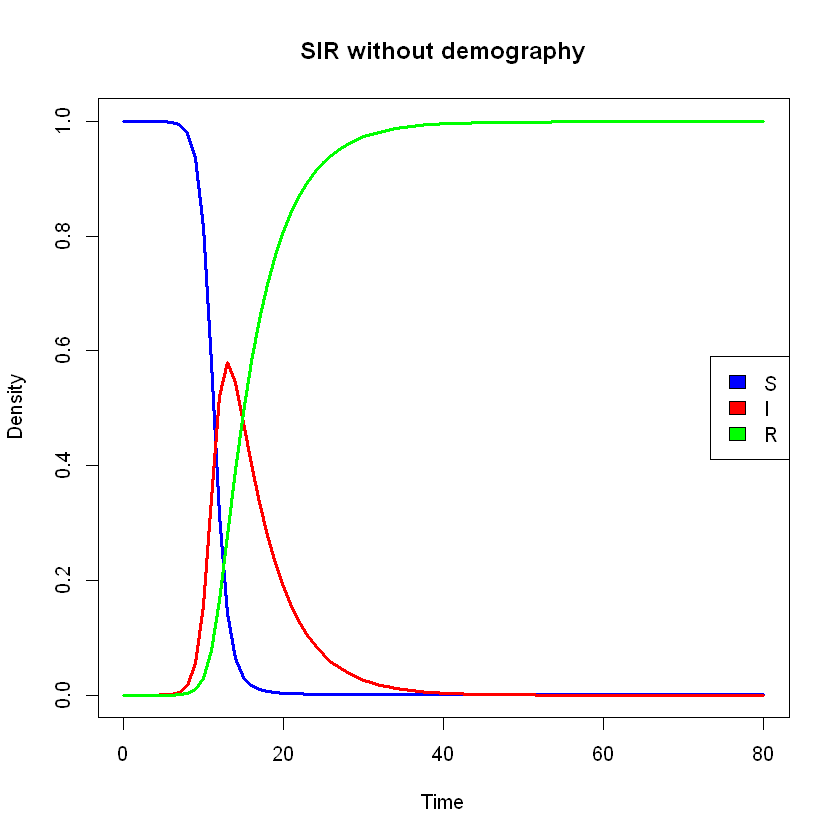

In [5]:
df<-as.data.frame(results)
plot(df[,1],df[,2],type="l",col="blue",lwd=3,xlab="Time",ylab="Density",main="SIR without demography")
lines(df[,1],df[,3],col="red",lwd=3)
lines(df[,1],df[,4],col="green",lwd=3)
legend("right",
c("S","I","R"),
fill=c("blue","red","green")
)

The infectious prevalence (that is, the proportion of infectious individuals) initially grows exponentially, but quickly slows down as the proportion of susceptible individuals decreases and the pathogen runs out of new people to infect. The infectious prevalence peaks somewhere around day 15, at which point the rate of recoveries begins to outstrip the rate of new infections. Eventually the infection dies out, with most of the population now recovered.

## 4. Basic reproductive ratio

One measure of the intensity of an outbreak is the basic reproductive ratio, denoted $R_0$. It is defined as *the expected number of secondary cases arising from a primary case in an entirely susceptible population*. The basic reproductive ratio is a *threshold parameter*; if $R_0<1$ then an outbreak of infection in a susceptible population will immediately die out, whereas when $R_0>1$ the infection can reach epidemic proportions. More generally, if the initial fraction of susceptibles $S(0)\leq \frac{1}{R_0}$, then $\frac{dI}{dt}<0$ and the infection dies out.

We can estimate $R_0$ for our SIR model without demography by considering the secondary cases generated by a single case introduced to a susceptible population. In this setting we expect all of the infectious contacts made by the infectious individual to be with susceptible individuals, so that the number of cases they generate per unit time is $\beta$. Since their expected infectious duration is $T=\gamma^{-1}$, we see that the basic reproductive ratio of the SIR model without demography is given by $R_0=\frac{\beta}{\gamma}$. Since $\beta$ is dependent on both biological factors (how much infection each case spreads) and social factors (how many contacts each case makes), it follows that the basic reproductive ratio is dependent on both the pathogen and the population in question.

One application of the basic reproductive ratio is estimating the **herd immunity threshold** for a given infection. This is the proportion of the population which needs to be immune to an infection to reduce the effective reproductive ratio to 1. The effective reproductive ratio (usually denoted $R_E$) can be intepreted as the mean number of cases generated by a single case after a control measure has been applied. Vaccination acts to control infection by reducing the proportion of susceptibles in the population, and will eradicate an infection when $S$ is reduced below $\frac{1}{R_0}$. The herd immunity threshold is thus given by $1-\frac{1}{R_0}$


Here are some reproduction numbers $R_0$ for common infectious diseases:

    - Ebola, 2014:          1.51 to 2.53
    - H1N1 Influenza, 2009: 1.46 to 1.48
    - Seasonal Influenza:   2 to 3
    - Measles:              12 to 18
    - MERS:                 around 1
    - Polio:                5 to 7
    - SARS:                 <1 to 2.75
    - Smallpox:             5 to 7
    - 2019-nCoV:            2 to 4

For the SARS pandemic in 2003, scientists estimated the original $R_0$ to be around 2.75. A month or two later, the effective $R_0$ dropped below 1, thanks to the tremendous effort that went into intervention strategies, including isolation and quarantine activities *(W5)*.

### *$\rightarrow$Try it yourself*
Experiment with different values of $\beta$ and $\gamma$ in the implementation of the SIR model we defined above. In particular, you should pay close attention to what happens when the ratio between $\beta$ and $\gamma$ is smaller than or greater than $1$.

In [6]:
## cell to use if needed




## 5. Other compartmental models 

Let's consider some other commonly used compartmental structures.


#### SIR with demography
If we wish to model the long-term persistence and endemic dynamics of an infectious disease, then we will need to bring demographic events into consideration. Births add to the pool of susceptibles, while deaths remove individuals from each compartment at a fixed per-capita rate. Note that here we are talking about "natural", rather than disease-induced, deaths.

To simplify this model, we often assume that the birth rate is equal to the death rate so that the population stays constant in time.
<img src="img/SIR_WithDemography.png" style="width: 40%;"/>

#### SIR with induced mortality
Many infectious agents are associated with a substantial level of mortality, e.g. malaria, dengue fever, SARS. In this scenario, we add a mortality rate to represent deaths from infection. Hence, an infectious individual can either recover or die.
<img src="img/SIR_WithInfectionDeaths.png" style="width: 40%;"/>

#### SIS dynamics

If an infection does not confer any immunity, then recovery will return infectious individuals to the susceptible pool. In this situation we obtain *Susceptible*$\to$*Infectious*$\to$*Susceptible* (SIS) dynamics. The SIS structure is commonly used to model sexually transmitted diseases, and can also be used to model gastrointestinal infections such as rotavirus.

<img src="img/SIS.png" style="width: 20%;"/>

### *$\rightarrow$Try it yourself*

- Copy the code from the SIR model above, and modify it to produce an implementation of the SIS model. Since there is no Recovered class in the SIS model, you should only have a two dimensional system of ODEs.
- Check the longterm dynamics of this model. How do they differ from an SIR?

In [7]:
## SIS dynamics




#### SEIR dynamics

For many important infections there is a significant incubation period during which the individual is infected but not yet infectious. During this period the individual is in the Exposed compartment ($E$). Once the incubation period is over, the individual moves to the pool of infecteds $I$.
<img src="img/SEIR.png" style="width: 40%;"/>

### *$\rightarrow$Try it yourself*
- Copy the code from the SIR example above and modify it to obtain an implementation of the SEIR model. In this case we have four compartments and so your ODE model should have four equations.
- How does including the incubation period enfluence the disease dynamics? Compare to an SIR.

In [8]:
## SEIR dynamics




#### MSIR
For many infections, including measles, babies can be born immune to the disease for the first few months of life due to protection from maternal antibodies, which is called *passive immunity*. Thus, such births produce hosts with a 'Maternally derived immunity' ($M$). This latter usually wanes with time until it moves the host to join the susceptibles.
<img src="img/MSIR.png" style="width: 50%;"/>
            
#### SIRC
In some infectious diseases, like hepatitis B, typhoid fever, tuberculosis or herpes, a proportion of the infecteds can become chronic carriers. They keep on transmitting the infection at a low rate for years, while not suffering symptoms. Thus, susceptibles can get infected by either infecteds or carriers.
<img src="img/SIRC.png" style="width: 30%;"/>

#### SI
When an infection always leads to fatality, we simplify the SIR model to an SI model.
<img src="img/SI.png" style="width: 30%;"/>


#### SIRS
If immunity lasts for a period of time before waning, we can model an SIRS model. A recovered person remains in the $R$ pool for a period of time, before going back to being a susceptible.
<img src="img/SIRS.png" style="width: 30%;"/>

#### SIRVT
We can also incorporate vaccination and treatment. Susceptible individuals who are vaccinated proceed to class $V$, at which point they are considered immune. Upon Treatment, infectious individuals ($I$) proceed to class $T$, at which point their infectiousness is reduced.
<img src="img/SIRVT.png" style="width: 30%;"/>

#### More complex models
Various examples of other compartmental models for infectious diseases can be found in the literature, ranging from the simplest to the very complex. For instance, we cite here the following examples:

The modelled transmission dynamics of the 1918 influenza pandemic in Geneva, Switzerland via the SEIRAJ model, which is an SEIR with asymptomatic and hospitalized/diagnosed and reported. It contains 6 classes: susceptible ($S$), exposed ($E$), clinically ill and infectious ($I$), asymptomatic and partially infectious ($A$), hospitalized/diagnosed and reported ($J$), and recovered ($R$). 
<img src="img/SEIRAJ.png" style="width: 45%;"/>

The second example describes an Ebola transmission model SEIRHF by (Legrand et al., 2007) with also 6 classes: susceptible ($S$), exposed ($E$), infectious in the community ($I$), infectious in the hospital ($H$), infectious after death at funeral ($F$), or recovered/removed ($R$). 
<img src="img/SEIRHF.png" style="width: 60%;"/>

The last example we're citing here is that of the vector-born modelling of Zika *(Suparit et al., 2018)*. It represents the transmission dynamics of the Zika disease between humans and mosquitoes. Susceptible humans ($S_H$) can be infected if they are bitten by infectious mosquitoes. Infected humans immediately become exposed ($E_H$) and then transition to the infectious class ($I_H$) after the intrinsic incubation period. Finally, infectious humans move to recovered class ($R_H$). Mosquitoes enter the susceptible class at birth and die naturally (from any class at a specific rate). If susceptible mosquitoes($S_v$) bite infectious humans, they are moved to the exposed ($E_v$) class and then become infectious ($I_v$).
<img src="img/ZIKV.png" style="width: 50%;"/>

## 6. SIR with demography  
To introduce demography, the most basic elements to add are usually natural births and deaths, both independent of the disease. 

<img src="img/SIR_WithDemography.png" style="width: 40%;"/>

The daily **death rate** $\mu$ depends on the host's average lifespan $\frac{1}{\mu}$. This death rate is independent of disease status, so that the rate at which we lose susceptible, infectious, and recovered individuals is respectively $\mu S$, $\mu I$ and $\mu R$.

In this model, we will assume that all newborns are susceptible to infection, although we note here that this is not the case in every model since sometimes we will want to explicitly model maternally-derived immunity. To keep our population size fixed, we will assume that our birth rate is equal to our death rate.

This gives us the following system of ODEs:
$\left\{\begin{array}{ll}
          \frac{dS}{dt}= \mu - \beta SI - \mu S\\
          \frac{dI}{dt}= \beta SI - \gamma I - \mu I\\
          \frac{dR}{dt}= \gamma I - \mu R
        \end{array}
      \right.$


### *$\rightarrow$Try it yourself*
- In an SIR with demography, does the equation $\sum_{C_i\in Classes} \frac{dC_i}{dt} = 0$ (see *section 3.2*) hold? Explain.

- In the next cell, write an implementation of the SIR model with demography by adding birth and death events to the SIR model without demography. Solve the equations using `desolve` and plot your solution for a few values of $\mu$. In general sensible values of $\mu$ will be somewhere around $\frac{1}{70*365}$, depending on the population we are modelling. Why do you think this is?

In [9]:
### Copy the necessary code from section 3.2 and use it to produce a plot for an SIR with demography dynamics

# function...



# prepare parameters...



# solve...




# plot results...





#### Basic reproductive ratio
If we assume $S_0=1$, then in an SIR with natural births and deaths we have $R_0=\frac{\beta}{\gamma + \mu}$

This $R_0$ is always close to the $R_0$ estimated in the absence of demography, but is slightly smaller.

#### Mean age of infection
The mean age of infection, noted $A$, is the average age at which susceptibles get infected. If multiple infections through lifetime is possible in the model, then we account for the first infection. It is calculated as $A\approx\frac{1}{\mu (R_0-1)}$

### *$\rightarrow$Try it yourself*

Write functions to calculate $R_0$ and $A$ for the SIR model with demography. Try calculating them for a few different sets of parameters $\beta$, $\gamma$, and $\mu$.

In [10]:
## Print R0

## Print the mean Age of infection



## 7. Equilibrium and stability 

#### Equilibrium state
Demographic turnover can allow a disease to persist in a population in the long term *(Keeling and Rohani, 2008)*. Essentially, births replace recovered individuals with susceptible ones and stop the pathogen from running out of people to infect.
At the equilibrium of our system of ODEs, $\frac{dS}{dt}=\frac{dI}{dt}=\frac{dR}{dt}=0$

When $R_0<1$, the SIR model with demography has a single equilibrium at $(S^*, I^*, R^*)=(1, 0, 0)$. When $R_0>1$, this is still an equilibrium, but we also find an endemic equilibrium at $(S^*, I^*, R^*) = (\frac{1}{R_0} , \frac{\mu}{\beta}(R_0-1) , 1-\frac{1}{R_0}-\frac{\mu}{\beta}(R_0-1))$.

#### Stability
Analysing the stability of equilibrium points indicates how the system behaves under small perturbations from equilibrium. If an equilibrium is stable, then when we move a small distance away from that equilibrium we should quickly return. If an equilibrium is unstable, then when we move a small distance away from that equilibrium we will carry on moving away indefinitely, or until we reach another equilibrium. A full stability analysis would involve linearising the system and calculating its eigenvalues(see, for example *(Arfken, 1985, W4)*), which we will not detail here. In the SIR model with demography, it turns out that when $R_0<1$ the single disease-free equilibrium is stable, so that if we introduce a small amount of disease we quickly return to the disease-free equilibrium. When $R_0>1$, the disease-free equilibrium is unstable and the endemic equilibrium is stable, so that if we are at endemic equilibrium and either add or remove some infection, the prevalence will quickly revert to its endemic level.

In case of a stable endemic equilibrium, a damped oscillatory behaviour can be noticed as the equilibrium is approached. The amplitude of the oscillations decrease over time until the equilibrium is achieved.
<img src="img/SIRwithDemogB.6G.2Mu5e-3.png" style="width: 80%;"/>

### *$\rightarrow$Try it yourself*
Using the code you wrote to implement the SIR model with demography, find parameter choices $(\beta , \gamma, \mu)$ so that the system tends towards:

- A disease-free equilibrium    
- An endemic equilibrium


## 8. Going further

- We suppose we have two outbreks with the same $\beta$ 
    - What could be said about them if we also have $\beta > \gamma$?
    - Try plotting outbreaks with $\gamma=\frac{1}{5}$ and $\gamma=\frac{1}{300}$ and compare their behavior. Think about the qualitative difference between these infections and how it impacts their longterm dynamics. You should try this out for a few values of $\beta$


- What could be said about the infectious process modelled by the following schematic? Write the corresponding equations and implement the model.

<img src="img/SI_withdemography2.png" style="width: 20%;"/>


- Consider the following  set of equations:

<center>$\left\{\begin{array}{ll}
          \frac{dS}{dt}= - \beta SI + \gamma_1 I - vR \\
          \frac{dI}{dt}= \beta SI - (\gamma_1+\gamma_2) I \\
          \frac{dR}{dt}= vR + \gamma_2 I 
        \end{array}
      \right.$</center>
      
   - What processes are happening in this model? Try drawing a diagram of the compartments.
   - What could $v$ represent?
   - We would like to add demography to this model. Suppose that the overall birth rate is $b$ and that out of each cohort of $b$ births, a total of $m$ newborns are born with a lifelong innate immunity to the infection. As usual, use $\mu$ to denote the natural death rate. Draw the model, update the corresponding equations, and implement the model in code.
   - What parameter choices will keep the population size fixed with time?


- Model and plot the dynamics of an SIRS with demography

In [11]:
## SIRS dynamics




- Model the dynamics of an SEIR with demography and disease induced mortality

In [12]:
## SEIR dynamics




## 9. Summary

- An outbreak of infectious disease can lead to epidemic, pandemic, or endemic infection.

- Deterministic mathematical models are often used when dealing with large populations. The results are always the same given a specific set of initial conditions.

- Stochastic models includes random elements within the model, they can give different outputs even with the same input parameters. 

- Compartmental modelling is a commonly used approach in infectious disease modelling.
- The basic reproductive ratio $R_0$ is the average number of secondary cases arising from an average primary case in an entirely susceptible population.

- If the initial fraction of susceptibles $S(0)\leq \frac{1}{R_0}$, then the infection dies out. 

- Vaccination helps reduce $S(0)$ below $\frac{1}{R_0}$ in order to eliminate the disease.

- The mean age of infection $A$ is the average age at which an individual becomes infected. 

- At endemic equilibrium, $S_0=\frac{1}{R_0}$

- In case of a stable endemic equilibrium, a damped oscillatory behaviour can be noticed as the equilibrium is approached. The amplitude of the oscillations decrease over time until the equilibrium is achieved.

## 10. References
- Arfken, G. "Eigenvectors, Eigenvalues." §4.7 in Mathematical Methods for Physicists, 3rd ed. Orlando, FL: Academic Press, pp. 229-237, 1985.
- Brauer, F. (2008). Compartmental models in epidemiology. Lecture Notes in Mathematics, 1945, 19–79. https://doi.org/10.1007/978-3-540-78911-6_2
- Chitnis, N. (2011). Einführung in die Mathematische Epidemiologie: Introduction to Mathematical Epidemiology: The Basic Reproductive Number. Retrieved from http://www.luchsinger‐mathematics.ch
- Choisy, M., Gugan, J.-F., & Rohani, P. (2007). Mathematical Modeling of Infectious Diseases Dynamics. Encyclopedia of Infectious Diseases, 379–404. https://doi.org/10.1002/9780470114209.ch22
- Keeling, Matt J., and Pejman Rohani. Modeling Infectious Diseases in Humans and Animals. Princeton University Press, 2008.
- Kermack, W. O., & McKendrick, A. G. (1927). A Contribution to the Mathematical Theory of Epidemics. Proceedings of the Royal Society A: Mathematical, Physical and Engineering Sciences, 115(772), 700–721. https://doi.org/10.1098/rspa.1927.0118
- Legrand J, Grais RF, Boelle PY, Valleron AJ, Flahault A. Understanding the dynamics of Ebola epidemics. Epidemiol Infect. 2007;4:610
- Suparit, Parinya & Wiratsudakul, Anuwat & Modchang, Charin. (2018). A mathematical model for Zika virus transmission dynamics with a time-dependent mosquito biting rate. Theoretical Biology and Medical Modelling. 15. 10.1186/s12976-018-0083-z
- W1 - https://en.wikipedia.org/wiki/Mathematical_modelling_of_infectious_disease
- W2 - https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#Bio-mathematical_deterministic_treatment_of_the_SIR_model
- W3 - https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology
- W4 - http://mathworld.wolfram.com/Eigenvalue.html
- W5 - http://theconversation.com/r0-how-scientists-quantify-the-intensity-of-an-outbreak-like-coronavirus-and-its-pandemic-potential-130777
